In [77]:
import tensorflow as tf

import tensorflow_datasets as tfds

from IPython.display import clear_output
import matplotlib.pyplot as plt

import os
import sys
import random

import numpy as np
import cv2

from tensorflow import keras
from tensorflow.keras import datasets, layers, models

In [78]:
dataset, info = tfds.load('oxford_iiit_pet:3.*.*', with_info=True)

In [79]:
image_size = 128

In [80]:
def normalize(input_image, input_mask):
  input_image = tf.cast(input_image, tf.float32) / 255.0
  input_mask -= 1
  return input_image, input_mask


@tf.function
def load_image_train(datapoint):
  input_image = tf.image.resize(datapoint['image'], (image_size, image_size))
  input_mask = tf.image.resize(datapoint['segmentation_mask'], (image_size, image_size))

  if tf.random.uniform(()) > 0.5:
    input_image = tf.image.flip_left_right(input_image)
    input_mask = tf.image.flip_left_right(input_mask)

  input_image, input_mask = normalize(input_image, input_mask)

  return input_image, input_mask 


def load_image_test(datapoint):
  input_image = tf.image.resize(datapoint['image'], (image_size, image_size))
  input_mask = tf.image.resize(datapoint['segmentation_mask'], (image_size, image_size))

  input_image, input_mask = normalize(input_image, input_mask)

  return input_image, input_mask

In [81]:
TRAIN_LENGTH = info.splits['train'].num_examples
BATCH_SIZE = 64
BUFFER_SIZE = 1000
STEPS_PER_EPOCH = TRAIN_LENGTH // BATCH_SIZE

print(TRAIN_LENGTH)
print(STEPS_PER_EPOCH)


3680
57


In [82]:
train = dataset['train'].map(load_image_train, num_parallel_calls=tf.data.experimental.AUTOTUNE)
test = dataset['test'].map(load_image_test)
                           
train_dataset = train.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()
train_dataset = train_dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
test_dataset = test.batch(BATCH_SIZE)                           

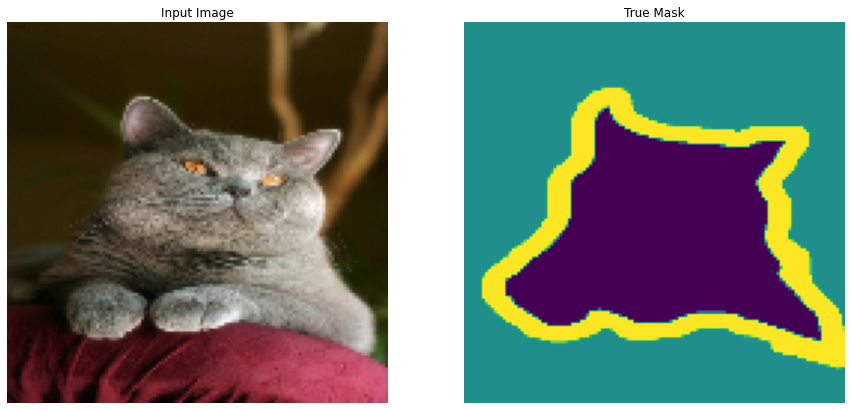

(128, 128, 3)


In [83]:
def display(display_list):
  plt.figure(figsize=(15, 15))

  title = ['Input Image', 'True Mask', 'Predicted Mask']

  for i in range(len(display_list)):
    plt.subplot(1, len(display_list), i+1)
    plt.title(title[i])
    plt.imshow(tf.keras.preprocessing.image.array_to_img(display_list[i]))
    plt.axis('off')
  plt.show()

for image, mask in train.take(3):
  sample_image, sample_mask = image, mask
display([sample_image, sample_mask])  

print(sample_image.shape)

In [84]:
def down_block(x, filters, kernel_size=(3, 3), padding="same", strides=1):
    c = keras.layers.Conv2D(filters, kernel_size, padding=padding, strides=strides, activation="relu")(x)
    c = keras.layers.Conv2D(filters, kernel_size, padding=padding, strides=strides, activation="relu")(c)
    p = keras.layers.MaxPool2D((2, 2), (2, 2))(c)
    return c, p

def up_block(x, skip, filters, kernel_size=(3, 3), padding="same", strides=1):
    us = keras.layers.UpSampling2D((2, 2))(x)
    concat = keras.layers.Concatenate()([us, skip])
    c = keras.layers.Conv2D(filters, kernel_size, padding=padding, strides=strides, activation="relu")(concat)
    c = keras.layers.Conv2D(filters, kernel_size, padding=padding, strides=strides, activation="relu")(c)
    return c

def bottleneck(x, filters, kernel_size=(3, 3), padding="same", strides=1):
    c = keras.layers.Conv2D(filters, kernel_size, padding=padding, strides=strides, activation="relu")(x)
    c = keras.layers.Conv2D(filters, kernel_size, padding=padding, strides=strides, activation="relu")(c)
    return c

In [90]:
def UNet():
  # ***************** STUDENTS : COMPLETE THIS FUNCTION ************************
  #     Your code should be only in this block
    input_shape=(image_size,image_size,3)
    input = keras.Input(shape = input_shape)
    c1, p1 = down_block(input,16)
    c2, p2 = down_block(p1,32)
    c3, p3 = down_block(p2,64)
    c4, p4 = down_block(p3, 128)
    c5 = bottleneck(p4,256)
    c6 = up_block(c5,c4,128)
    c7 = up_block(c6, c3, 64)
    c8 = up_block(c7, c2, 32)
    c9 = up_block(c8, c1, 16)
    o = layers.Conv2D(3, (3,3), padding="same", strides=1, activation="relu")(c9)
    return keras.Model(inputs=input, outputs=o)
  # ***************** STUDENTS : YOUR CODE ENDS HERE ************************

In [91]:
model = UNet()
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])
model.summary()

Model: "model_6"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_23 (InputLayer)          [(None, 128, 128, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_271 (Conv2D)            (None, 128, 128, 16  448         ['input_23[0][0]']               
                                )                                                                 
                                                                                                  
 conv2d_272 (Conv2D)            (None, 128, 128, 16  2320        ['conv2d_271[0][0]']             
                                )                                                           

In [92]:
def create_mask(pred_mask):
  pred_mask = tf.argmax(pred_mask, axis=-1)
  pred_mask = pred_mask[..., tf.newaxis]
  return pred_mask[0]

def show_predictions(dataset=None, num=1):
  if dataset:
    for image, mask in dataset.take(num):
      pred_mask = model.predict(image)
      display([image[0], mask[0], create_mask(pred_mask)])
  else:
    display([sample_image, sample_mask,
             create_mask(model.predict(sample_image[tf.newaxis, ...]))])

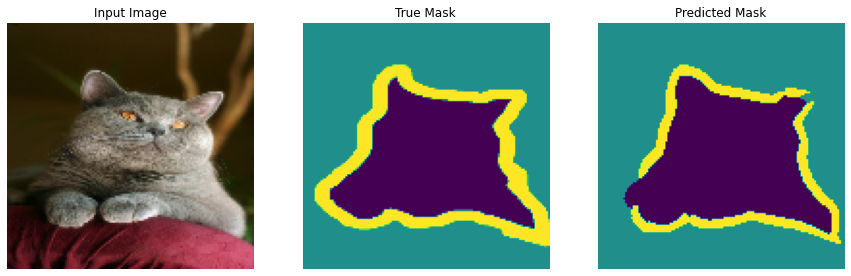


Sample Prediction after epoch 15

57/57 [==============================] - 792s 14s/step - loss: 0.3324 - accuracy: 0.8629 - val_loss: 0.3759 - val_accuracy: 0.8500


In [93]:
class DisplayCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs=None):
    clear_output(wait=True)
    show_predictions()
    print ('\nSample Prediction after epoch {}\n'.format(epoch+1))



EPOCHS = 15
VAL_SUBSPLITS = 5
VALIDATION_STEPS = info.splits['test'].num_examples//BATCH_SIZE//VAL_SUBSPLITS

model_history = model.fit(train_dataset, epochs=EPOCHS,
                          steps_per_epoch=STEPS_PER_EPOCH,
                          validation_steps=VALIDATION_STEPS,
                          validation_data=test_dataset,
                          callbacks=[DisplayCallback()])

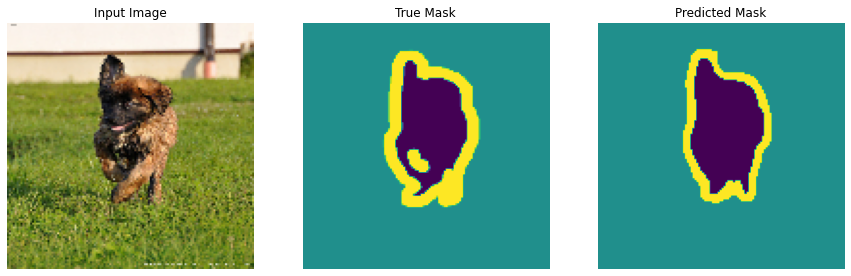

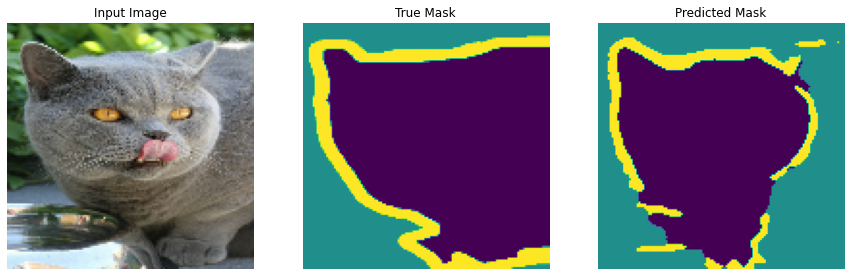

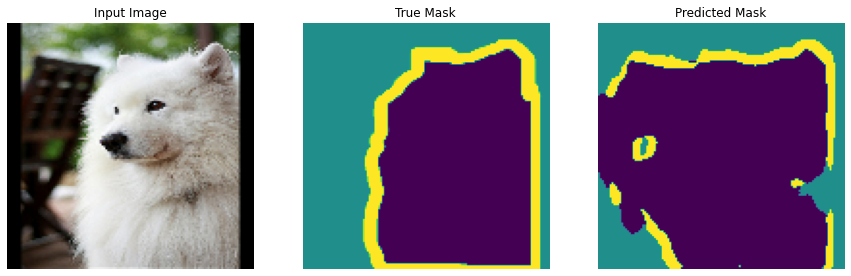

In [94]:
show_predictions(test_dataset, 3)      